# Анализ поведения пользователей мобильного приложения по продаже продуктов питания

###### Краткое описание проекта

Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?
Проект состоит из двух частей. В первой части мы иисследуем воронку продаж и ответим на вопросы как пользователи доходят до покупки, сколько, сколько не проходит на следующий этап. Во второй части мы исследуем результаты А/А/В-теста с тремя контрольными группами(две одинаковые со старым решением и одна с новым) и посмотрим как изменение шрифтов в приложении влияет на поведение пользователей.

###### Цели и основные задачи проекта

Целью первой части проекта является определение количества пользователей, которые доходят до оплаты и установления возможных причин почему другая часть пользователей не доходят до оплаты. Целью второй части является принятия решения о результатах А/А/В-теста: продолжать или останавливать и фиксировать победу в пользу одной из групп (либо отсутствие различий между ними).

## Подготовка данных

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import math as mth
import plotly.express as px

In [35]:
df = pd.read_csv('logs_exp.csv',sep='\t')
df.head()

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [37]:
#переименуем столбцы в более читаемые и приведём дату к нужному типу
df = df.rename(columns={'EventName':'event_name','DeviceIDHash':'user_id','EventTimestamp':'event_ts','ExpId':'group'})

In [38]:
df['event_dt'] = pd.to_datetime(df['event_ts'],unit='s')
df.head()

,event_name,user_id,event_ts,group,event_dt
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42


In [39]:
df.duplicated().sum()

413

In [40]:
df.isna().sum()

event_name    0
user_id       0
event_ts      0
group         0
event_dt      0
dtype: int64

Пропусков не обнаружено, полных дубликатов 413. Это ~0.17% от всех данных. Смело удаляем

In [41]:
df = df.drop_duplicates()
df.duplicated().sum()

0

In [42]:
#создадим доп. столбец с датой без времени
df['event_date'] = df['event_dt'].dt.date
df['event_date'] = pd.to_datetime(df['event_date'])
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   event_name  243713 non-null  object        
 1   user_id     243713 non-null  int64         
 2   event_ts    243713 non-null  int64         
 3   group       243713 non-null  int64         
 4   event_dt    243713 non-null  datetime64[ns]
 5   event_date  243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB
None


,event_name,user_id,event_ts,group,event_dt,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25


Удалим теперь уже не нужный нам столбец event_ts, а также переименуем группы 246, 247, 248 в А1, А2 и В соответственно

In [43]:
df = df.drop(columns={'event_ts'})
df = df.replace({'group' : { 246 : 'A1', 247 : 'A2', 248 : 'B' }})
df.head()

,event_name,user_id,group,event_dt,event_date
0,MainScreenAppear,4575588528974610257,A1,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,A1,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,B,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,B,2019-07-25 11:48:42,2019-07-25


### Вывод

Данные предобработали, почистили дубликаты, переименовали столбцы и навзания исследуемых групп в более читаемые.

## Изучение и проверка данных

In [44]:
#посмотрим сколько всего событий в данных и какие уникальные события есть
df['event_name'].count()

243713

In [45]:
#посмотрим сколько всего пользователей
df['user_id'].nunique()

7551

In [46]:
#cколько в среднем событий приходится на пользователя
event_per_user = df.groupby('user_id').agg({'event_name':'count'}).reset_index()
event_per_user['event_name'].mean()

32.27559263673685

In [47]:
#посмотрим за какой период у нас данные
print('минимальная дата:', df['event_dt'].min())
print('максимальная дата:', df['event_dt'].max())

минимальная дата: 2019-07-25 04:43:36
максимальная дата: 2019-08-07 21:15:17


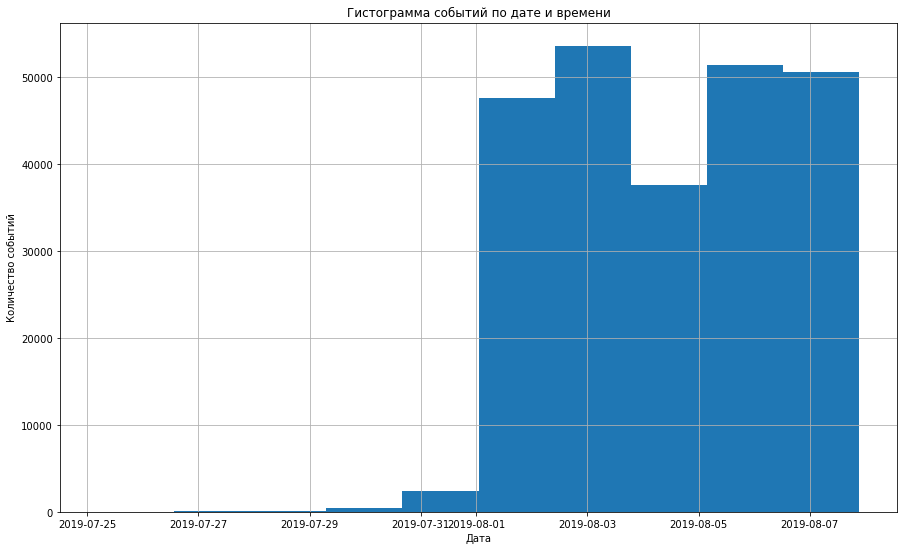

In [48]:
#посмотрим гистограмму по дате и времени
df['event_dt'].hist(figsize=(15,9))
plt.title('Гистограмма событий по дате и времени')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
None

Видим, что до 2019-08-01 очень мало данных. Возьмем эту дату за точку отсчёта "полных данных", отбросим более старые и посмотрим сколько событий и пользователей мы потярем

In [49]:
df_filtered = df[df['event_date']>='2019-08-01']
print('Событий отсеялось после фильтрации в %:', round(100 - (df_filtered['event_name'].count()*100/df['event_name'].count()),2))
print('Пользователей отсеялось после фильтрации в %', round(100 - (df_filtered['user_id'].nunique()*100/df['user_id'].nunique()),2))

Событий отсеялось после фильтрации в %: 1.16
Пользователей отсеялось после фильтрации в % 0.23


Довольно малый процент данных отсеялся, но мы будем уверены, что он теперь не будет перекашивать данные, поэтому дальше продолжим работать с фльтрованными логами

In [50]:
#Проверим, что у нас есть пользователи из всех трёх экспериментальных групп
users_per_group = df_filtered.groupby('group')['user_id'].nunique()
users_per_group

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

### Вывод

Изучили данные, проверили целостность, "отрезали" хваот с неполными данными, чтобы они не искажали последующие иследования.

## Изучение воронки событий

In [51]:
#Посмотрим какие события есть в логах и как часто они встречаются
events_count = df_filtered.groupby('event_name')['event_name'].count().sort_values(ascending=False)
events_count

event_name
MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

In [52]:
#Определим сколько пользователей совершали каждое из этих событий и долю пользователей, которые хоть раз совершали событие
events_users_count = df_filtered.groupby('event_name').agg({'user_id':'nunique'}).reset_index().sort_values(by='user_id',ascending=False)
events_users_count

,event_name,user_id
1,MainScreenAppear,7419
2,OffersScreenAppear,4593
0,CartScreenAppear,3734
3,PaymentScreenSuccessful,3539
4,Tutorial,840


In [53]:
#Доля пользователей, которые хоть раз совершали событие
events_users_count['%_of_all'] =round(100*events_users_count['user_id']/df_filtered['user_id'].nunique(),2)

По названию событий можем предположить следующий порядок: MainScreenAppear(вход в приложение/главный экран) -> OffersScreenAppear (экран товара) -> CartScreenAppear (корзина) -> PaymentScreenSuccessful (успешная оплата заказа). Tutorial, судя по количеству пользователей, опциональный - его мы не будем включать при построении воронки.

In [54]:
events_users_count = events_users_count.rename(columns={'user_id':'users'})

In [55]:
events_users_count = events_users_count[events_users_count['event_name']!='Tutorial']
events_users_count

,event_name,users,%_of_all
1,MainScreenAppear,7419,98.47
2,OffersScreenAppear,4593,60.96
0,CartScreenAppear,3734,49.56
3,PaymentScreenSuccessful,3539,46.97


In [56]:
#Посчитаем какая доля пользователей проходит на следующий шаг воронки
events_users_count['%_from_previous_event'] = round(100*events_users_count['users']/events_users_count['users'].shift(),2)
events_users_count = events_users_count.reset_index(drop=True)
events_users_count

,event_name,users,%_of_all,%_from_previous_event
0,MainScreenAppear,7419,98.47,NaN
1,OffersScreenAppear,4593,60.96,61.91
2,CartScreenAppear,3734,49.56,81.30
3,PaymentScreenSuccessful,3539,46.97,94.78


<p>Больше всего пользователей теряется на шаге OffersScreenAppear</p>
Определим долю пользователей, которые доходят от первого шага до оплаты

In [57]:
print('Доля пользователей доходящих от первого шага до оплаты:',round(100*events_users_count.loc[events_users_count.index.max(),'users']/events_users_count.loc[events_users_count.index.min(),'users'],2))

Доля пользователей доходящих от первого шага до оплаты: 47.7


Визуализируем воронку

In [58]:
px.funnel(events_users_count, x='users', y='event_name')

### Вывод

По результатам исследования продуктовой воронки установили, что больше всего пользователей теряется на шаге OffersScreenAppear,а всего до шага оплаты доходит 47,7% пользователей.

## Изучение результатов А/А/В-теста

In [59]:
#Количество пользователей в каждой из групп
users_per_group

group
A1    2484
A2    2513
B     2537
Name: user_id, dtype: int64

In [60]:
#Проверим, что каждый пользователь состоит лишь в одной группе
df_filtered.groupby('user_id')['group'].nunique().unique()

array([1], dtype=int64)

In [61]:
#Разделим выборку по группам
group_A1 = df_filtered[df_filtered['group']=='A1']
group_A2 = df_filtered[df_filtered['group']=='A2']
group_B = df_filtered[df_filtered['group']=='B']

Выберем самое популярное событие.

In [62]:
df_filtered.groupby('event_name')['user_id'].nunique().sort_values(ascending=False)

event_name
MainScreenAppear           7419
OffersScreenAppear         4593
CartScreenAppear           3734
PaymentScreenSuccessful    3539
Tutorial                    840
Name: user_id, dtype: int64

Посчитаем число пользователей, совершивших это событие в каждой из контрольных групп. Посчитаем долю пользователей, совершивших это событие.

In [63]:
print('Число пользователей, совершиших событие MainScreenAppear в группе А1:',group_A1[group_A1['event_name']=='MainScreenAppear']['user_id'].nunique())
print('Число пользователей, совершиших событие MainScreenAppear в группе А2:',group_A2[group_A2['event_name']=='MainScreenAppear']['user_id'].nunique())
print('Число пользователей, совершиших событие MainScreenAppear в группе В:',group_B[group_B['event_name']=='MainScreenAppear']['user_id'].nunique())

Число пользователей, совершиших событие MainScreenAppear в группе А1: 2450
Число пользователей, совершиших событие MainScreenAppear в группе А2: 2476
Число пользователей, совершиших событие MainScreenAppear в группе В: 2493


In [64]:
print('Доля пользователей, совершиших событие MainScreenAppear в группе А1:',round(100*group_A1[group_A1['event_name']=='MainScreenAppear']['user_id'].nunique()/group_A1['user_id'].nunique(),2))
print('Доля пользователей, совершиших событие MainScreenAppear в группе А2:',round(100*group_A2[group_A2['event_name']=='MainScreenAppear']['user_id'].nunique()/group_A2['user_id'].nunique(),2))
print('Доля пользователей, совершиших событие MainScreenAppear в группе B:',round(100*group_B[group_B['event_name']=='MainScreenAppear']['user_id'].nunique()/group_B['user_id'].nunique(),2))

Доля пользователей, совершиших событие MainScreenAppear в группе А1: 98.63
Доля пользователей, совершиших событие MainScreenAppear в группе А2: 98.53
Доля пользователей, совершиших событие MainScreenAppear в группе B: 98.27


Посмотрим какое количество пользователей совершило каждое действие по каждой группе

In [65]:
group_per_event_pivot = df_filtered.pivot_table(index='event_name',columns='group',values='user_id', aggfunc='nunique').sort_values(by=['A1','A2','B'],ascending=False)
group_per_event_pivot

group,A1,A2,B
event_name,,,
MainScreenAppear,2450,2476,2493
OffersScreenAppear,1542,1520,1531
CartScreenAppear,1266,1238,1230
PaymentScreenSuccessful,1200,1158,1181
Tutorial,278,283,279


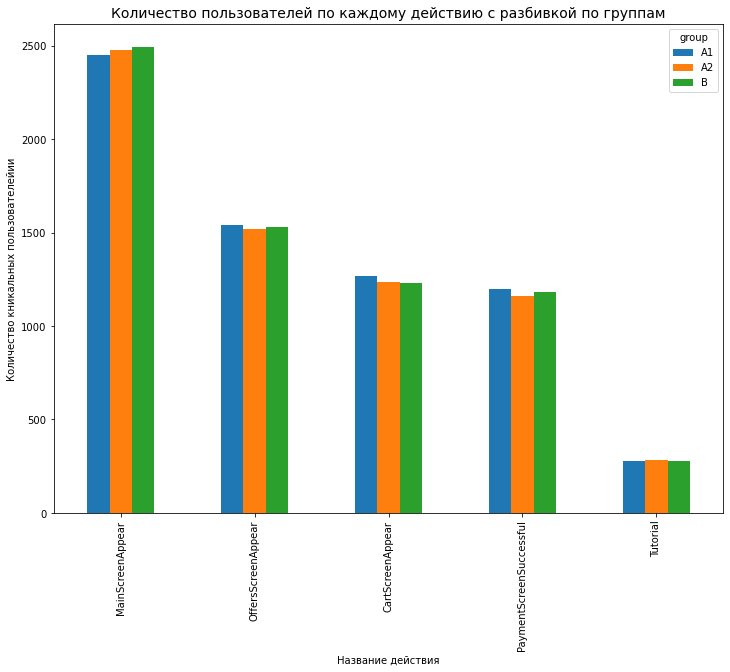

In [66]:
group_per_event_pivot.plot(kind='bar',figsize=(12,9))
plt.title('Количество пользователей по каждому действию с разбивкой по группам', fontsize=14)
plt.xlabel('Название действия')
plt.ylabel('Количество кникальных пользователейии')
None

Визуальных различий нет. Проверим стат. значимость различия между группами в разрезе каждого действия.

Проверим, находят ли статистические критерии разницу между выборками групп А1 и А2 по уникальным юзерам по каждому событию

In [67]:
#Напишем функцию для проверки стат значимости разницы долей выборок по разным событиям
def z_test (group_1,group_2,event_name,alpha,group_1_name,group_2_name,z_test_counter=[0]):
    z_test_counter[0]+=1
    all_users_group_1 = group_1['user_id'].nunique()
    all_users_group_2 = group_2['user_id'].nunique()
    event_success_users_group_1 = group_1[group_1['event_name']==event_name]['user_id'].nunique()
    event_success_users_group_2 = group_2[group_2['event_name']==event_name]['user_id'].nunique()
    # пропорция успехов в первой группе:
    p1 = event_success_users_group_1/all_users_group_1
    # пропорция успехов во второй группе:
    p2 = event_success_users_group_2/all_users_group_2
    # пропорция успехов в комбинированном датасете:
    p_combined = (event_success_users_group_1 + event_success_users_group_2) / (all_users_group_1 + all_users_group_2)
    # разница пропорций в датасетах
    difference = p1 - p2 
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/all_users_group_1 + 1/all_users_group_2))
    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print(f'Сравнение стат. значимости долей между группой {group_1_name} и группой {group_2_name} по событию {event_name}')
    print('Критический уровень статистической значимости:',alpha)
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )
    print(f'Эксперимент номер {z_test_counter}') 

In [68]:
z_test(group_A1,group_A2,'MainScreenAppear',0.05,'A1','A2')

Сравнение стат. значимости долей между группой A1 и группой A2 по событию MainScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.7570597232046099
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [1]


In [69]:
z_test(group_A1,group_A2,'OffersScreenAppear',0.05,'A1','A2')

Сравнение стат. значимости долей между группой A1 и группой A2 по событию OffersScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.2480954578522181
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [2]


In [70]:
z_test(group_A1,group_A2,'CartScreenAppear',0.05,'A1','A2')

Сравнение стат. значимости долей между группой A1 и группой A2 по событию CartScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.22883372237997213
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [3]


In [71]:
z_test(group_A1,group_A2,'PaymentScreenSuccessful',0.05,'A1','A2')

Сравнение стат. значимости долей между группой A1 и группой A2 по событию PaymentScreenSuccessful
Критический уровень статистической значимости: 0.05
p-значение:  0.11456679313141849
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [4]


In [72]:
z_test(group_A1,group_A2,'Tutorial',0.05,'A1','A2')

Сравнение стат. значимости долей между группой A1 и группой A2 по событию Tutorial
Критический уровень статистической значимости: 0.05
p-значение:  0.9376996189257114
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [5]


Z-тест не показал статистически значимых отличий между выборками А1 и А2. Считаем, что разбиение на контрольные группы корректно.

Теперь сравним результаты с каждой из контрольных групп в отдельности по каждому событию с наблюдаемой группой (В). Tutorial проверять не будем, т.к. считаем что он необязательный

In [73]:
z_test(group_A1,group_B,'MainScreenAppear',0.05,'A1','B')

Сравнение стат. значимости долей между группой A1 и группой B по событию MainScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.2949721933554552
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [6]


In [74]:
z_test(group_A1,group_B,'OffersScreenAppear',0.05,'A1','B')

Сравнение стат. значимости долей между группой A1 и группой B по событию OffersScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.20836205402738917
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [7]


In [75]:
z_test(group_A1,group_B,'CartScreenAppear',0.05,'A1','B')

Сравнение стат. значимости долей между группой A1 и группой B по событию CartScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.07842923237520116
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [8]


In [76]:
z_test(group_A1,group_B,'PaymentScreenSuccessful',0.05,'A1','B')

Сравнение стат. значимости долей между группой A1 и группой B по событию PaymentScreenSuccessful
Критический уровень статистической значимости: 0.05
p-значение:  0.2122553275697796
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [9]


In [77]:
z_test(group_A2,group_B,'MainScreenAppear',0.05,'A2','B')

Сравнение стат. значимости долей между группой A2 и группой B по событию MainScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.4587053616621515
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [10]


In [78]:
z_test(group_A2,group_B,'OffersScreenAppear',0.05,'A2','B')

Сравнение стат. значимости долей между группой A2 и группой B по событию OffersScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.9197817830592261
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [11]


In [79]:
z_test(group_A2,group_B,'CartScreenAppear',0.05,'A2','B')

Сравнение стат. значимости долей между группой A2 и группой B по событию CartScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.5786197879539783
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [12]


In [80]:
z_test(group_A2,group_B,'PaymentScreenSuccessful',0.05,'A2','B')

Сравнение стат. значимости долей между группой A2 и группой B по событию PaymentScreenSuccessful
Критический уровень статистической значимости: 0.05
p-значение:  0.7373415053803964
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [13]


Статистически знамиых различий между контрольными группами А1 и А2 и группой В не выявлено. Проверим то же самое для объединённой контрольной групы А1+А2 и группы В

In [81]:
group_A1_A2 = df_filtered[df_filtered['group']!='B']

In [82]:
z_test(group_A1_A2,group_B,'MainScreenAppear',0.05,'A1+A2','B')

Сравнение стат. значимости долей между группой A1+A2 и группой B по событию MainScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.29424526837179577
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [14]


In [83]:
z_test(group_A1_A2,group_B,'OffersScreenAppear',0.05,'A1+A2','B')

Сравнение стат. значимости долей между группой A1+A2 и группой B по событию OffersScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.43425549655188256
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [15]


In [84]:
z_test(group_A1_A2,group_B,'CartScreenAppear',0.05,'A1+A2','B')

Сравнение стат. значимости долей между группой A1+A2 и группой B по событию CartScreenAppear
Критический уровень статистической значимости: 0.05
p-значение:  0.18175875284404386
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [16]


In [85]:
z_test(group_A1_A2,group_B,'PaymentScreenSuccessful',0.05,'A1+A2','B')

Сравнение стат. значимости долей между группой A1+A2 и группой B по событию PaymentScreenSuccessful
Критический уровень статистической значимости: 0.05
p-значение:  0.6004294282308704
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
Эксперимент номер [17]


Стат. значимых различий между объединённой контрольной группой А1+А2 и группой В нет.

Суммарно было проведено 17 проверок с уровнем стат. значимости 5%. При применении уровня значимости 10%, основываясь на предыдущих экспериментах, проверку не пройдёт только 1 эксперимент "Сравнение стат. значимости долей между группой A1 и группой B по событию CartScreenAppear", остальные будут успешными. Оставим значение значимости в 5%.

### Вывод

Статистически значимых различий между конверсиями групп А1, А2 и В не обнаружено, показатели примерно одинаковые. Можем сделать вывод, что изменение шрифтов в приложении никак не влияет на конверсию пользователей и оставить любой из вариантов шрифтов.